In [2]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
#from sklearn.model_selection import KFold
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import skimage.io as io
import skimage.transform as trans
from keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint,
    CSVLogger,
    TensorBoard,
)


os.environ['CUDA_VISIBLE_DEVICES'] = '1'
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.6
set_session(tf.Session(config=config))

DATA_DIR = '/data/krf/dataset'
ROOT_DIR = '/data/krf/model/rsna'

# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

train_dicom_dir = os.path.join(DATA_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_1_test_images')
train_seg_dir = os.path.join(DATA_DIR, 'stage_1_train_segmentations')
test_seg_dir = os.path.join(DATA_DIR, 'stage_1_test_segmentations')

Using TensorFlow backend.


In [3]:
model_dir = ROOT_DIR
dir_names = next(os.walk(model_dir))[1]
#print(dir_names)
key = 'pneumonia'
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)
print(dir_names)
if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(model_dir))
fps = []
best_epoch = 10
# Pick last directory
#for d in dir_names: 
d = dir_names[-1]    
dir_name = os.path.join(model_dir, d)
# Find the last checkpoint
checkpoints = next(os.walk(dir_name))[2]
#print(checkpoints)
checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
checkpoints = sorted(checkpoints)
if not checkpoints:
    print('No weight files in {}'.format(dir_name))
else:
    print(checkpoints)
    checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
    fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

['pneumonia20181009T1301', 'pneumonia20181009T1439', 'pneumonia20181011T1739', 'pneumonia20181013T1301', 'pneumonia20181016T1658', 'pneumonia20181016T2058', 'pneumonia20181018T1030', 'pneumonia20181019T2207', 'pneumonia20181020T1154', 'pneumonia20181020T1606', 'pneumonia20181020T2103']
['mask_rcnn_pneumonia_0001.h5', 'mask_rcnn_pneumonia_0002.h5', 'mask_rcnn_pneumonia_0003.h5', 'mask_rcnn_pneumonia_0004.h5', 'mask_rcnn_pneumonia_0005.h5', 'mask_rcnn_pneumonia_0006.h5', 'mask_rcnn_pneumonia_0007.h5', 'mask_rcnn_pneumonia_0008.h5', 'mask_rcnn_pneumonia_0009.h5', 'mask_rcnn_pneumonia_0010.h5', 'mask_rcnn_pneumonia_0011.h5', 'mask_rcnn_pneumonia_0012.h5', 'mask_rcnn_pneumonia_0013.h5', 'mask_rcnn_pneumonia_0014.h5', 'mask_rcnn_pneumonia_0015.h5']
Found model /data/krf/model/rsna/pneumonia20181020T2103/mask_rcnn_pneumonia_0011.h5


In [4]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 5
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.4  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.1

    STEPS_PER_EPOCH = 1600
config = DetectorConfig()

Loading weights from  /data/krf/model/rsna/pneumonia20181020T2103/mask_rcnn_pneumonia_0011.h5


  0%|          | 0/1000 [00:00<?, ?it/s]

Re-starting from epoch 11


100%|██████████| 1000/1000 [02:10<00:00,  7.04it/s]


/data/krf/model/rsna/seg_submission1022.csv
x 476 y 400 h 216 w 388
x 108 y 488 h 192 w 292
x 152 y 536 h 212 w 204
x 540 y 176 h 328 w 556
x 276 y 184 h 136 w 156
x 232 y 584 h 216 w 144
x 384 y 444 h 68 w 84
x 744 y 576 h 160 w 176
x 224 y 504 h 176 w 192
x 588 y 420 h 236 w 256
x 352 y 488 h 100 w 124
x 624 y 436 h 84 w 144
x 316 y 572 h 116 w 168
x 220 y 488 h 200 w 124
x 624 y 572 h 160 w 136
x 352 y 244 h 148 w 92
x 200 y 480 h 204 w 196
x 692 y 628 h 152 w 136
x 728 y 552 h 108 w 104
x 592 y 592 h 148 w 204
x 172 y 632 h 184 w 144
x 224 y 352 h 96 w 132
x 168 y 384 h 216 w 272
x 736 y 468 h 96 w 100
x 608 y 508 h 208 w 264
x 580 y 236 h 244 w 316
x 188 y 160 h 252 w 404


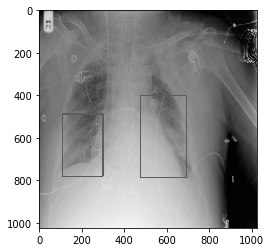

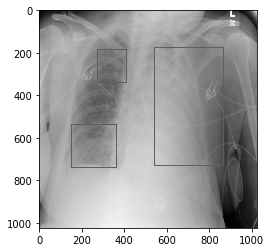

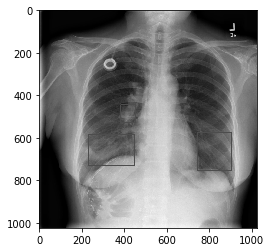

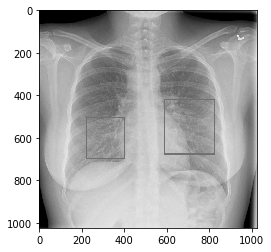

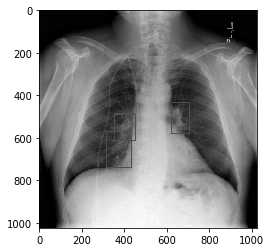

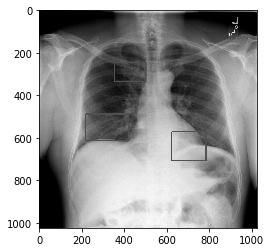

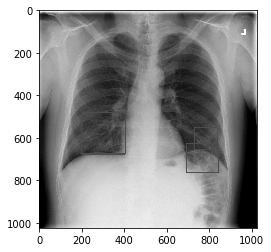

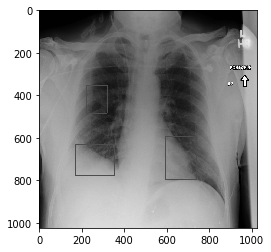

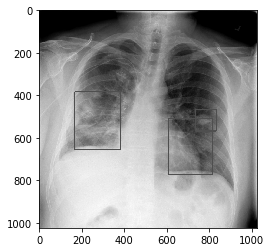

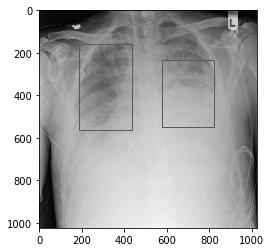

In [4]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


# # Show few example of ground truth vs. predictions on the validation dataset 
# dataset = dataset_val
# fig = plt.figure(figsize=(10, 30))

# for i in range(6):

#     image_id = random.choice(dataset.image_ids)
    
#     original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#         modellib.load_image_gt(dataset_val, inference_config, 
#                                image_id, use_mini_mask=False)
    
#     print(original_image.shape)
#     plt.subplot(6, 2, 2*i + 1)
#     visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                                 dataset.class_names,
#                                 colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
#     plt.subplot(6, 2, 2*i + 2)
#     results = model.detect([original_image]) #, verbose=1)
#     r = results[0]
#     visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                                 dataset.class_names, r['scores'], 
#                                 colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])


# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)


# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.98):
    # assume square image
    # resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    resize_factor = 4
    #resize_factor = ORIG_SIZE
   
    
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")
        
        for image_id in tqdm(image_fps):
            patient_id = os.path.splitext(os.path.basename(image_id))[0]
            pid = image_id.split('/')[-1].split('.')[0]
            image = cv2.imread(os.path.join(test_seg_dir,pid+".png"))
            #image = trans.resize(image,(1024,1024))
            #image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(int(x1*resize_factor), int(y1*resize_factor), \
                                                           int(width*resize_factor), int(height*resize_factor))
                        out_str += bboxes_str

            file.write(out_str+"\n")

submission_fp = os.path.join(ROOT_DIR, 'seg_submission1022.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

output = pd.read_csv(submission_fp)
output.head(60)

# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    # original image 
    o_image = ds.pixel_array
    #seg
    pid = image_id.split('/')[-1].split('.')[0]
    #print(pid)
    image = cv2.imread(os.path.join(test_seg_dir,pid+".png"))
    #image = trans.resize(image,(1024,1024))
    # assume square image 
    #resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    resize_factor = 4
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    #print(patient_id)
    #plt.imshow(resized_image, cmap=plt.cm.gist_gray)
    results = model.detect([resized_image])
    #print(results[0])
    r = results[0]
    for bbox in r['rois']: 
        #print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2] * resize_factor)
        
        cv2.rectangle(o_image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        #print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(o_image, cmap=plt.cm.gist_gray)
    plt.savefig(ROOT_DIR+"/"+patient_id+".png")
show_num =10
for _ in range(show_num):
    visualize()


Loading weights from  /data/krf/model/rsna/pneumonia20181020T2103/mask_rcnn_pneumonia_0011.h5


  0%|          | 0/1000 [00:00<?, ?it/s]

Re-starting from epoch 11


100%|██████████| 1000/1000 [00:21<00:00, 46.44it/s]


/data/krf/model/rsna/classified_seg_submission1022.csv


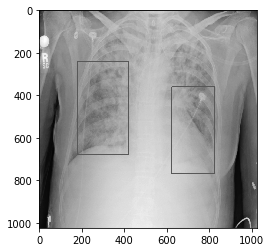

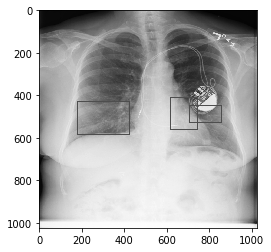

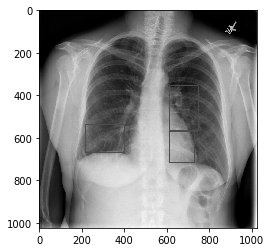

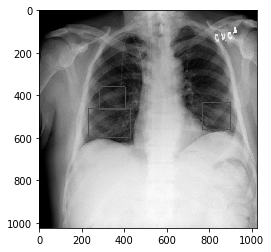

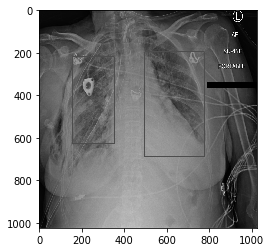

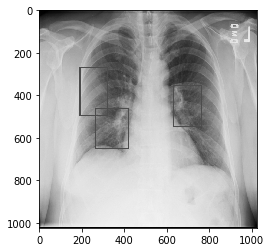

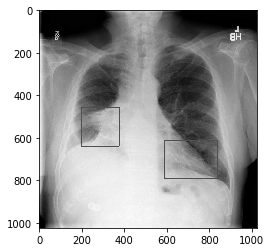

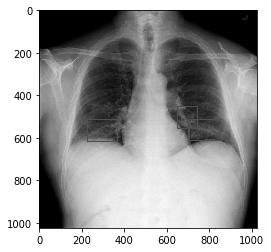

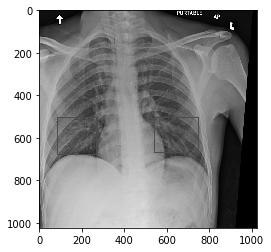

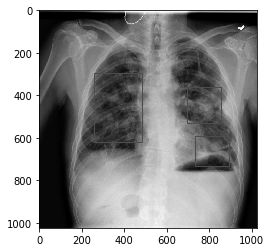

In [5]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


# # Show few example of ground truth vs. predictions on the validation dataset 
# dataset = dataset_val
# fig = plt.figure(figsize=(10, 30))

# for i in range(6):

#     image_id = random.choice(dataset.image_ids)
    
#     original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#         modellib.load_image_gt(dataset_val, inference_config, 
#                                image_id, use_mini_mask=False)
    
#     print(original_image.shape)
#     plt.subplot(6, 2, 2*i + 1)
#     visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                                 dataset.class_names,
#                                 colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
#     plt.subplot(6, 2, 2*i + 2)
#     results = model.detect([original_image]) #, verbose=1)
#     r = results[0]
#     visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                                 dataset.class_names, r['scores'], 
#                                 colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])


# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)


# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    # resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    resize_factor = 4
    #resize_factor = ORIG_SIZE
    labelFile = 'stage_1_test_labels.csv'
    test_labels = pd.read_csv(labelFile)
    
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")
        
        for image_id in tqdm(image_fps):
            patient_id = os.path.splitext(os.path.basename(image_id))[0]
            out_str = ""
            out_str += patient_id
            out_str += ","
            #print(patient_id)
            tmp = test_labels[test_labels['patientId']==patient_id]
            #print(tmp)
            #print(tmp['Target'])
            tmp = tmp['Target']==0
            #print(tmp)
            if tmp.bool():
                #print("pass: ",patient_id)
                pass
            else:
                #ds = pydicom.read_file(image_id)
                pid = image_id.split('/')[-1].split('.')[0]
                image = cv2.imread(os.path.join(test_seg_dir,pid+".png"))
                #image = trans.resize(image,(1024,1024))
                #image = ds.pixel_array
                # If grayscale. Convert to RGB for consistency.
                if len(image.shape) != 3 or image.shape[2] != 3:
                    image = np.stack((image,) * 3, -1)
                image, window, scale, padding, crop = utils.resize_image(
                    image,
                    min_dim=config.IMAGE_MIN_DIM,
                    min_scale=config.IMAGE_MIN_SCALE,
                    max_dim=config.IMAGE_MAX_DIM,
                    mode=config.IMAGE_RESIZE_MODE)



                results = model.detect([image])
                r = results[0]


                assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
                if len(r['rois']) == 0:
                    pass
                else:
                    num_instances = len(r['rois'])

                    for i in range(num_instances):
                        if r['scores'][i] > min_conf:
                            out_str += ' '
                            out_str += str(round(r['scores'][i], 2))
                            out_str += ' '

                            # x1, y1, width, height
                            x1 = r['rois'][i][1]
                            y1 = r['rois'][i][0]
                            width = r['rois'][i][3] - x1
                            height = r['rois'][i][2] - y1
                            bboxes_str = "{} {} {} {}".format(int(x1*resize_factor), int(y1*resize_factor), \
                                                               int(width*resize_factor), int(height*resize_factor))
                            out_str += bboxes_str
            file.write(out_str+"\n")

submission_fp = os.path.join(ROOT_DIR, 'classified_seg_submission1022.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

output = pd.read_csv(submission_fp)
output.head(60)

# show a few test image detection example
def visualize(): 
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)
    # original image 
    o_image = ds.pixel_array
    #seg
    pid = image_id.split('/')[-1].split('.')[0]
    #print(pid)
    image = cv2.imread(os.path.join(test_seg_dir,pid+".png"))
    #image = trans.resize(image,(1024,1024))
    # assume square image 
    #resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    resize_factor = 4
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    #print(patient_id)
    #plt.imshow(resized_image, cmap=plt.cm.gist_gray)
    results = model.detect([resized_image])
    #print(results[0])
    r = results[0]
    for bbox in r['rois']: 
        #print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2] * resize_factor)
        
        cv2.rectangle(o_image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
        #print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure() 
    plt.imshow(o_image, cmap=plt.cm.gist_gray)
    plt.savefig(ROOT_DIR+"/"+patient_id+".png")
show_num =10
for _ in range(show_num):
    visualize()
